In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score



def test_ensemble(X_train, y_train, X_test, y_test):
    clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
    clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
    clf3 = GaussianNB()
    # X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
    # y = np.array([1, 1, 1, 2, 2, 2])

    eclf1 = VotingClassifier(estimators=[
             ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
                             voting='hard')
    eclf1 = eclf1.fit(X_train, y_train)
    eclf1_pred = eclf1.predict(X_test)

    np.array_equal(eclf1.named_estimators_.lr.predict(X_test),
                    eclf1.named_estimators_['lr'].predict(X_test))

    eclf2 = VotingClassifier(estimators=[
             ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
             voting='soft')
    eclf2 = eclf2.fit(X_train, y_train)
    eclf2_pred = eclf2.predict(X_test)


    eclf3 = VotingClassifier(estimators=[
            ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
            voting='soft', weights=[2,1,1],
            flatten_transform=True)
    eclf3 = eclf3.fit(X_train, y_train)
    eclf3_pred = eclf3.predict(X_test)
    #print(eclf3.transform(X_test).shape)
    
    return accuracy_score(y_test, eclf1_pred), accuracy_score(y_test, eclf2_pred), accuracy_score(y_test, eclf3_pred)

In [2]:
df = pd.read_csv('./data/galaxy.csv')
df_cleaned = pd.read_csv('./data/galaxy-cleaned.csv', index_col=0)
df_cleaned_scaled = pd.read_csv('./data/galaxy-cleaned-scaled.csv', index_col=0)

In [185]:
df_cleaned.head()

,BuyItNow,startprice,hasDescription,upperCaseDescription,sold,has_carrier,has_color,has_productline,modelNumber,isNote
0,0,199.99,0,0,1,1,1,1,3,0
1,0,235.00,0,0,0,1,0,1,3,1
2,0,199.99,1,1,0,0,0,0,2,0
3,1,175.00,0,0,1,1,1,1,3,1
4,1,100.00,0,0,1,1,1,1,2,0


In [11]:
df.groupby('productline')['startprice'].mean().sort_values(ascending=False)

productline
Galaxy_Note10    366.931311
Galaxy_S10       294.583750
Galaxy_Note9     254.561402
Galaxy_S9        231.268101
Galaxy_Note8     176.065033
Unknown          171.994265
Galaxy_S8        165.883321
Galaxy_S7         84.190000
Name: startprice, dtype: float64

In [22]:
df['productline'] = df['productline'].apply(\
                                lambda x: re.sub('[^0-9]', '', x) if x.startswith('G') else '8')

In [24]:
df.groupby('productline')['startprice'].mean().sort_values(ascending=False)

productline
10    365.319109
9     240.673321
8     170.306719
7      84.190000
Name: startprice, dtype: float64

In [25]:
df.groupby('productline')['startprice'].count().sort_values(ascending=False)

productline
8     634
10    359
9     265
7     227
Name: startprice, dtype: int64

In [38]:
df = df.drop(['carrier', 'color', 'noDescription', 'charCountDescription', 'upperCaseDescription'],
       axis=1)

# Find Outlier by Models

In [47]:
model7 = df['productline']=='7'
model8 = df['productline']=='8'
model9 = df['productline']=='9'
model10 = df['productline']=='10'

BIN0 = df['BuyItNow']==0
BIN1 = df['BuyItNow']==1

sold0 = df['sold'] == 0
sold1 = df['sold'] == 1

<AxesSubplot:xlabel='startprice', ylabel='Count'>

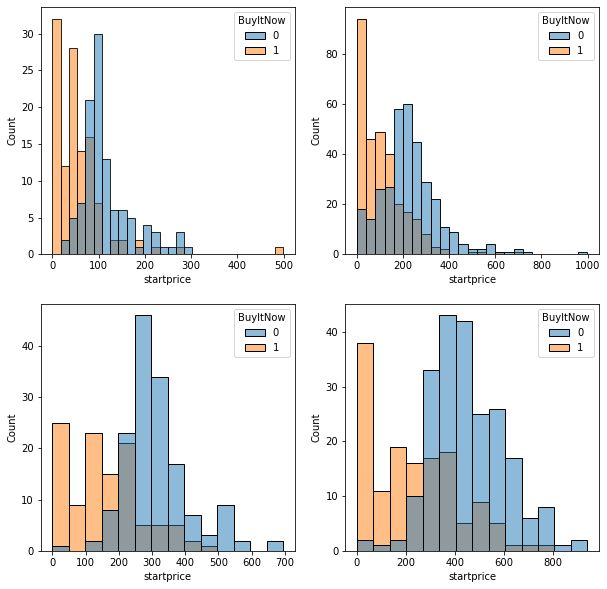

In [81]:
fig, axes = plt.subplots(2,2, figsize=(10, 10))
fig.figsize=(20,20)
sns.histplot(x=df[model7]['startprice'], data=df[model7],
            hue='BuyItNow', ax=axes[0][0])
sns.histplot(x=df[model8]['startprice'], data=df[model8],
            hue='BuyItNow', ax=axes[0][1])
sns.histplot(x=df[model9]['startprice'], data=df[model9],
            hue='BuyItNow', ax=axes[1][0])
sns.histplot(x=df[model10]['startprice'], data=df[model10],
            hue='BuyItNow', ax=axes[1][1])

In [116]:
clf = LocalOutlierFactor(n_neighbors=4)
y_pred = clf.fit_predict(df.drop('sold', axis=1))
lof_outlier_idx = pd.Series(y_pred)[pd.Series(y_pred)==-1].index
print(len(lof_outlier_idx))
df.iloc[lof_outlier_idx]

385


,BuyItNow,startprice,productline,sold
6,1,150.00,9,1
10,0,75.00,7,1
12,0,344.95,10,0
13,0,184.50,8,1
14,0,209.98,9,0
...,...,...,...,...
1474,0,129.99,7,0
1476,0,219.95,8,0
1477,0,279.00,8,0
1480,0,89.50,7,0


In [117]:
clf = LocalOutlierFactor(n_neighbors=4, contamination=.1)
y_pred = clf.fit_predict(df.drop('sold', axis=1))
lof_outlier_idx2 = pd.Series(y_pred)[pd.Series(y_pred)==-1].index
print(len(lof_outlier_idx2))
df.iloc[lof_outlier_idx2]

149


,BuyItNow,startprice,productline,sold
6,1,150.00,9,1
10,0,75.00,7,1
27,0,299.98,10,0
58,0,79.99,7,1
61,0,279.99,10,0
...,...,...,...,...
1458,1,49.95,8,1
1465,1,52.25,8,0
1469,0,249.99,10,1
1480,0,89.50,7,0


# `df_lof`

In [120]:
df_lof = df.drop(lof_outlier_idx2)

In [121]:
model7 = df_lof['productline']=='7'
model8 = df_lof['productline']=='8'
model9 = df_lof['productline']=='9'
model10 = df_lof['productline']=='10'

BIN0 = df_lof['BuyItNow']==0
BIN1 = df_lof['BuyItNow']==1

sold0 = df_lof['sold'] == 0
sold1 = df_lof['sold'] == 1

<AxesSubplot:xlabel='startprice', ylabel='Count'>

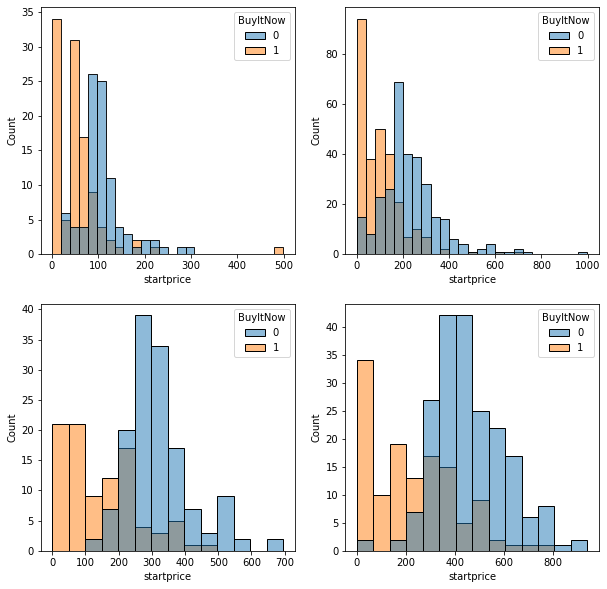

In [122]:
fig, axes = plt.subplots(2,2, figsize=(10, 10))
fig.figsize=(20,20)
sns.histplot(x=df_lof[model7]['startprice'], data=df_lof[model7],
            hue='BuyItNow', ax=axes[0][0])
sns.histplot(x=df_lof[model8]['startprice'], data=df_lof[model8],
            hue='BuyItNow', ax=axes[0][1])
sns.histplot(x=df_lof[model9]['startprice'], data=df_lof[model9],
            hue='BuyItNow', ax=axes[1][0])
sns.histplot(x=df_lof[model10]['startprice'], data=df_lof[model10],
            hue='BuyItNow', ax=axes[1][1])

<AxesSubplot:xlabel='startprice', ylabel='Count'>

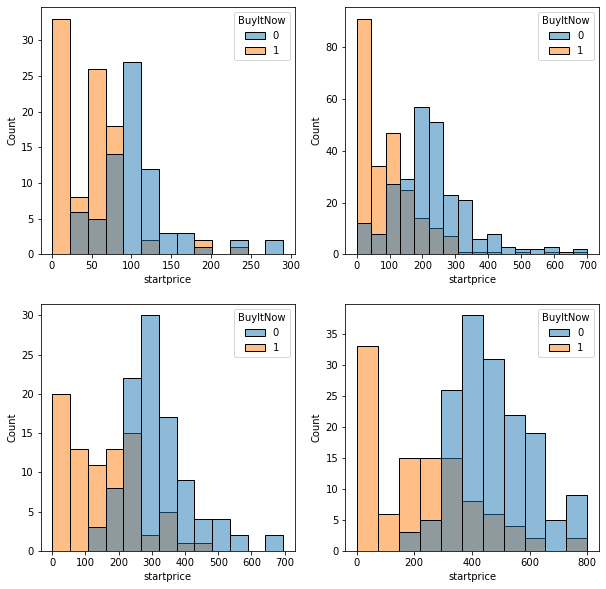

In [223]:
df_lof2 = df.drop(lof_outlier_idx)

model7 = df_lof2['productline']=='7'
model8 = df_lof2['productline']=='8'
model9 = df_lof2['productline']=='9'
model10 = df_lof2['productline']=='10'

BIN0 = df_lof2['BuyItNow']==0
BIN1 = df_lof2['BuyItNow']==1

sold0 = df_lof2['sold'] == 0
sold1 = df_lof2['sold'] == 1

fig, axes = plt.subplots(2,2, figsize=(10, 10))
fig.figsize=(20,20)
sns.histplot(x=df_lof2[model7]['startprice'], data=df_lof2[model7],
            hue='BuyItNow', ax=axes[0][0])
sns.histplot(x=df_lof2[model8]['startprice'], data=df_lof2[model8],
            hue='BuyItNow', ax=axes[0][1])
sns.histplot(x=df_lof2[model9]['startprice'], data=df_lof2[model9],
            hue='BuyItNow', ax=axes[1][0])
sns.histplot(x=df_lof2[model10]['startprice'], data=df_lof2[model10],
            hue='BuyItNow', ax=axes[1][1])

In [125]:
X = df.drop('sold', axis=1)
y = df.sold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [188]:
X0 = df_cleaned.drop('sold', axis=1)
y0 = df_cleaned.sold
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.2, random_state=11)

In [126]:
X1 = df_lof.drop('sold', axis=1)
y1 = df_lof.sold
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=11)

In [224]:
X2 = df_lof2.drop('sold', axis=1)
y2 = df_lof2.sold
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=11)

In [206]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)
accuracy_score(y_test, lr.predict(X_test))

0.7744107744107744

In [202]:
test_ensemble(X_train, y_train, X_test, y_test)

(0.7777777777777778, 0.7811447811447811, 0.7845117845117845)

In [201]:
lr = LogisticRegression(random_state=0)
lr.fit(X1_train, y1_train)
accuracy_score(y1_test, lr.predict(X1_test))

0.832089552238806

In [205]:
test_ensemble(X1_train, y1_train, X1_test, y1_test)

(0.832089552238806, 0.8134328358208955, 0.8208955223880597)

### GridCV for LogReg

In [199]:
def test_grid(model, X_train, y_train, X_test, y_test, p):
    params = p
    model = model #RandomForestClassifier(random_state=0, n_jobs=-1)
    grid_cv = GridSearchCV(model, param_grid=params,
                           cv=StratifiedKFold(n_splits=5),
                           n_jobs=-1)
    grid_cv.fit(X_train, y_train)
    pred = grid_cv.best_estimator_.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print(accuracy)
    return grid_cv

In [211]:
logreg_p = {"C":np.logspace(-3, 3, 30),
             "penalty":["l1","l2"],
           "solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
           "tol":np.logspace(-6, 1, 30)}# l1 lasso l2 ridge
lr = LogisticRegression(multi_class='auto', random_state=0)
logreg_grid = test_grid(lr, X1_train, y1_train, X1_test, y1_test, logreg_p)

0.8208955223880597


In [212]:
logreg_grid.best_params_

{'C': 0.0727895384398315,
 'penalty': 'l2',
 'solver': 'newton-cg',
 'tol': 3.2903445623126713}

In [ ]:
logreg_grid2 = test_grid(lr, X2_train, y2_train, X2_test, y2_test, logreg_p)

# Error Analysis

In [213]:
def result_df(grid_cv_fit, X, y):
    
    X_pred = pd.DataFrame(grid_cv_fit.predict(X),
                          columns=['sold_pred'])
    X_pred_proba = pd.DataFrame(grid_cv_fit.predict_proba(X),
                                columns=['sold0_proba', 'sold1_proba'])
    y = pd.DataFrame(y, columns=['sold'])
    
    res_df = pd.concat([X, y, X_pred, X_pred_proba], axis=1)
    res_df['wrong_pred'] = res_df['sold'] != res_df['sold_pred']
    
    return res_df

In [222]:
confusion_matrix(y1_test, logreg_grid.predict(X1_test))

array([[120,  17],
       [ 31, 100]])

In [221]:
pd.Series(logreg_grid.predict(X1)).value_counts()

0    760
1    576
dtype: int64

In [216]:
result_df(logreg_grid, X1, y1)

,BuyItNow,startprice,productline,sold,sold_pred,sold0_proba,sold1_proba,wrong_pred
0,0.0,199.99,9,1.0,0.0,0.617393,0.382607,True
1,0.0,235.00,9,0.0,0.0,0.672549,0.327451,False
2,0.0,199.99,8,0.0,0.0,0.691982,0.308018,False
3,1.0,175.00,9,1.0,1.0,0.292842,0.707158,False
4,1.0,100.00,8,1.0,1.0,0.255878,0.744122,False
...,...,...,...,...,...,...,...,...
1478,0.0,319.00,8,0.0,NaN,NaN,NaN,True
1479,0.0,424.99,10,1.0,NaN,NaN,NaN,True
1481,0.0,239.95,9,1.0,NaN,NaN,NaN,True
1482,0.0,329.99,10,0.0,NaN,NaN,NaN,True


# 차원의 저주와 싸우기
1. https://excelsior-cjh.tistory.com/167
2. https://hoony-gunputer.tistory.com/entry/핸즈온-머신러닝8강-차원축소-2편

### PCA

In [139]:
from sklearn.decomposition import PCA, KernelPCA

In [155]:
pca = PCA(n_components=3)
pca.fit(df) # df
pca.explained_variance_ratio_

array([9.99962374e-01, 2.54005566e-05, 8.40860825e-06])

In [165]:
pca = PCA(n_components=5)
pca.fit(df_cleaned) # df
pca.explained_variance_ratio_

array([9.99922157e-01, 2.85947233e-05, 1.61500802e-05, 9.13356157e-06,
       7.80591226e-06])

In [166]:
df_original = pd.read_csv('./data/galaxy.csv')

In [167]:
rbf_pca = KernelPCA(n_components=1, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(df.drop('sold', axis=1))

In [150]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])

param_grid = [{
    "kpca_gamma":np.linspace(0.03, 0.05, 10),
    "kpca_kernel":["rbf", "sigmoid"]
},
{'random_state':[0, 1]}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X1_train,y1_train)

ValueError: Invalid parameter kpca_gamma for estimator Pipeline(memory=None,
         steps=[('kpca',
                 KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3,
                           eigen_solver='auto', fit_inverse_transform=False,
                           gamma=None, kernel='linear', kernel_params=None,
                           max_iter=None, n_components=2, n_jobs=None,
                           random_state=None, remove_zero_eig=False, tol=0)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False). Check the list of available parameters with `estimator.get_params().keys()`.

# Locally Linear Embedding
출처: https://excelsior-cjh.tistory.com/168?category=918734 [EXCELSIOR]

In [186]:
from sklearn.manifold import LocallyLinearEmbedding

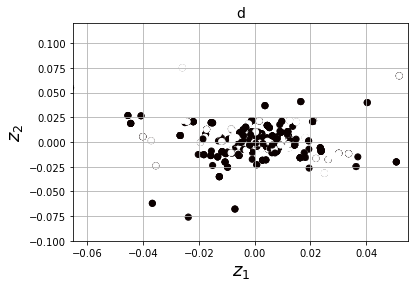

In [195]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=2, random_state=42, eigen_solver='dense')
lle.fit(X1)
X1_reduced = lle.transform(X1)
plt.title("d", fontsize=14)
plt.scatter(X1_reduced[:, 0], X1_reduced[:, 1], c=y1, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)
plt.show()

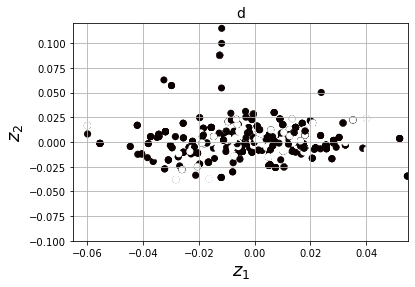

In [196]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=2, random_state=42, eigen_solver='dense')
lle.fit(X0)
X0_reduced = lle.transform(X0)
plt.title("d", fontsize=14)
plt.scatter(X0_reduced[:, 0], X0_reduced[:, 1], c=y0, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)
plt.show()

# SVM


In [135]:
from sklearn import svm

In [194]:
svm_clf = svm.SVC(kernel='rbf')
svm_clf.fit(X1_train, y1_train)
accuracy_score(y1_test, svm_clf.predict(X1_test))

0.7052238805970149

In [197]:
X1_rdc_train, X1_rdc_test, y1_rdc_train, y1_rdc_test = train_test_split(
                                        X1_reduced, y1, test_size=0.2, random_state=11)

svm_clf = svm.SVC(kernel='rbf')
svm_clf.fit(X1_rdc_train, y1_rdc_train)
accuracy_score(y1_rdc_test, svm_clf.predict(X1_rdc_test))

0.5335820895522388

In [191]:
svm_clf = svm.SVC()
svm_clf.fit(X0_train, y0_train)
accuracy_score(y0_test, svm_clf.predict(X0_test))

0.7104377104377104

In [137]:
svm_clf = svm.SVC()
svm_clf.fit(X_train, y_train)
accuracy_score(y_test, svm_clf.predict(X_test))

0.7104377104377104

# DF2

In [7]:
df2 = df_cleaned.copy()
df2 = df2.drop(['hasDescription', 'upperCaseDescription', 'has_carrier', 'has_color', 'has_productline'],
              axis=1)

In [8]:
df2.head()

,BuyItNow,startprice,sold,modelNumber,isNote
0,0,199.99,1,3,0
1,0,235.00,0,3,1
2,0,199.99,0,2,0
3,1,175.00,1,3,1
4,1,100.00,1,2,0


In [ ]:
df2.groupby()